# Testing a new contribution


In [1]:
import numpy as np
import pandas as pd

from deep_nilmtk.utils.templates import ExperimentTemplate
from deep_nilmtk.models.pytorch import Seq2Point
from deep_nilmtk.models.pytorch.layers import *
from deep_nilmtk.disaggregator import NILMExperiment
from deep_nilmtk.data.loader import GeneralDataLoader

import torch.nn as nn

In [2]:
DATA_PATH = '../../data/ukdale.h5'
EXPERIMENT_NAME = 'seq2point_variants'
RESULTS_PATH = '../../seq2point_variants'

## Defining the model

we will here extend the seq2point with a residal connection.

``` python
class seq2point_residual(Seq2point):
    def __init__(self, params):
        self.model = Seq
        pass

    def forward(self,x ):
        y_pred = x

        return y_pred
    

    def step(self, batch):
        x, y  = batch
        return  loss, mae

    def predict(self,  model, test_dataloader):
        
        return results
    
    @staticmethod
    def get_template():
        params={}
        return params
```

In [3]:
class Residual_block(nn.Module):
    def __init__(self, in_size, out_size, filter_size=5):
        super(Residual_block, self).__init__() 
        self.conv = nn.Sequential(create_conv1(in_size, 30, filter_size, bias=True, stride=1, padding=(filter_size-1)//2),
                                  create_conv1(30, out_size, filter_size, bias=True, stride=1, padding=(filter_size-1)//2),
                                  nn.BatchNorm1d(out_size),
                                  nn.ReLU())

    def forward(self,x):
        out = x + self.conv(x)
        return out
    
class ResidualSeq2Point(Seq2Point):
    def __init__(self, params):
        super(ResidualSeq2Point, self).__init__(params)
        self.enc_net = nn.Sequential(Residual_block(self.in_size, 50, 7),
                                     Residual_block(50, 50, 7),
                                     nn.Dropout(0.2),
                                     nn.AdaptiveAvgPool1d(self.pool_filter),
                                     nn.Flatten())

        self.fc = nn.Sequential(nn.Linear(50*self.pool_filter, self.output_size))

In [4]:
class SmallSeq2Point(Seq2Point):
    def __init__(self, params):
        super(SmallSeq2Point, self).__init__(params)
        self.enc_net = nn.Sequential(create_conv1(self.in_size, 30, 10, bias=True, stride=1),
                                     create_conv1(30, 40, 8, bias=True, stride=1),
                                     nn.BatchNorm1d(40),
                                     nn.ReLU(),
                                     create_conv1(40, 50, 7, bias=True, stride=1),
                                     create_conv1(50, 50, 5, bias=True, stride=1),
                                     nn.BatchNorm1d(50),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.AdaptiveAvgPool1d(self.pool_filter),
                                     nn.Flatten())

        self.fc = nn.Sequential(nn.Linear(50*self.pool_filter, self.output_size))

## Defining the data loader

The interface for defining a custom model is as follows:

```python 

class new_nilm_loader(torch.utils.data.Dataset):
    
    def __init__(self, params):
        pass

    def __len__(self):
        pass


    def __getitem__(self, index):
        pass

    def __copy__(self):
        return self
    
```

Nonethless, for the considered model we can directly use the pre-defined data loader as the model follows a learning seq2seq approach.


## Benchmarking with existing baselines

In [14]:
max_epochs = 20
template = ExperimentTemplate( data_path=DATA_PATH,
                 template_name='ukdale',
                 list_appliances=['washing machine'],
                 list_baselines_backends=[('Seq2Pointbaseline', 'pytorch')],
                 in_sequence=121,
                 out_sequence=1,
                 max_epochs=max_epochs)

In [15]:
small_seq2point = NILMExperiment({
                "model_class": SmallSeq2Point,
                "loader_class": GeneralDataLoader,
                "model_name": 'small_s2p',
                'backend':'pytorch',
                'in_size': 121,
                'out_size':1,
                'custom_preprocess':None,
                'feature_type':'mains',
                'input_norm':'z-norm',
                'target_norm':'z-norm',
                'seq_type':'seq2point',
                'point_position':'mid_position',
                'learning_rate':10e-5,
                'max_nb_epochs': max_epochs
                })

In [16]:
residual_seq2point = NILMExperiment({
                "model_class": ResidualSeq2Point,
                "loader_class": GeneralDataLoader,
                "model_name": 'residual_s2p',
                'backend':'pytorch',
                'in_size': 121,
                'out_size':1,
                'custom_preprocess':None,
                'feature_type':'mains',
                'input_norm':'z-norm',
                'target_norm':'z-norm',
                'seq_type':'seq2point',
                'point_position':'mid_position',
                'learning_rate':10e-5,
                'max_nb_epochs': max_epochs
                })

In [17]:
template.extend_experiment({
    'residual_s2p': residual_seq2point, 
    'small_s2p' : small_seq2point
})

template.__print__()

"
        The current experiment is based on template ukdale
        Appliances ['washing machine']
        NILM MODELS ['Seq2Pointbaseline', 'residual_s2p', 'small_s2p']
        Dataset path ../../data/ukdale.h5
            - sampling rate :8
            - training data 
                - uses following buildings 1
                - uses following buildings 1
            - testing data
                - uses following buildings 1
        


In [ ]:
template.run_template(EXPERIMENT_NAME,
                     RESULTS_PATH,
                     f'{RESULTS_PATH}/mlflow')

Started training for  residual_s2p
Joint training for  residual_s2p
............... Loading Data for training ...................
Loading data for  ukdale  dataset
Loading building ...  1
Dropping missing values


2022/03/14 09:27:36 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint path at ../../seq2point_variants/checkpoints/washing machine/residual_s2p/version_0\epoch=4-step=60914.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restored all states from the checkpoint file at ../../seq2point_variants/checkpoints/washing machine/residual_s2p/version_0\epoch=4-step=60914.ckpt

  | Name  | Type              | Params
--------------------------------------------
0 | model | ResidualSeq2Point | 32.9 K
--------------------------------------------
32.9 K    Trainable params
0         Non-trainable params
32.9 K    Total params
0.131     Total estimated model params size (MB)


<class '__main__.ResidualSeq2Point'>
Training: 0it [00:00, ?it/s]                                                                                           

2022/03/14 09:27:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d074ef31800846c593566a16b4895035. Failed operations: [MlflowException(MlflowException("Changing param values is not allowed. Param with key=\'weight_decay\' was already logged with value=\'0.0\' for run ID=\'d074ef31800846c593566a16b4895035\'. Attempted logging new value \'0\'."))]')]


Epoch 5:  85%|███████████████████████████████████▋      | 12183/14333 [02:29<00:26, 81.39it/s, loss=0.0977, v_num=ent0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  94%|███████████████████████████████████████▋  | 13525/14333 [02:36<00:09, 86.50it/s, loss=0.0977, v_num=ent0]


Epoch 5: 100%|██████████| 14333/14333 [02:40<00:00, 89.31it/s, loss=0.0977, v_num=ent0, val_loss=0.087, val_mae=0.0882]
Epoch 6:  85%|▊| 12183/14333 [02:39<00:28, 76.18it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Validating: 0it [00:00, ?it/s]
Epoch 6:  85%|▊| 12188/14333 [02:39<00:28, 76.19it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  85%|▊| 12210/14333 [02:40<00:27, 76.28it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  85%|▊| 12232/14333 [02:40<00:27, 76.36it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  85%|▊| 12254/14333 [02:40<00:27, 76.45it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  86%|▊| 12276/14333 [02:40<00:26, 76.53it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  86%|▊| 12298/14333 [02:40<00:26, 76.62it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6: 

Validating:  25%|████████████████▎                                                 | 533/2150 [00:02<00:07, 202.54it/s]
Epoch 6:  89%|▉| 12738/14333 [02:42<00:20, 78.26it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  89%|▉| 12760/14333 [02:42<00:20, 78.34it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  89%|▉| 12782/14333 [02:42<00:19, 78.42it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  89%|▉| 12804/14333 [02:43<00:19, 78.50it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  89%|▉| 12826/14333 [02:43<00:19, 78.58it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  90%|▉| 12848/14333 [02:43<00:18, 78.66it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  90%|▉| 12870/14333 [02:43<00:18, 78.73it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  90%|▉| 12892/14333 [02:43<00:1

Epoch 6:  98%|▉| 14058/14333 [02:49<00:03, 82.91it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  98%|▉| 14080/14333 [02:49<00:03, 82.99it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  98%|▉| 14102/14333 [02:49<00:02, 83.07it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  99%|▉| 14124/14333 [02:49<00:02, 83.14it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  99%|▉| 14146/14333 [02:49<00:02, 83.22it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  99%|▉| 14168/14333 [02:50<00:01, 83.30it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  99%|▉| 14190/14333 [02:50<00:01, 83.37it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  99%|▉| 14212/14333 [02:50<00:01, 83.45it/s, loss=0.126, v_num=ent0, val_loss=0.087, val_mae=0.0882, train_los
Epoch 6:  99%|▉| 14234/14333 [02:50<00:0

Epoch 7:  92%|▉| 13222/14333 [02:39<00:13, 82.69it/s, loss=0.174, v_num=ent0, val_loss=0.0857, val_mae=0.0973, train_lo
Epoch 7:  92%|▉| 13244/14333 [02:40<00:13, 82.77it/s, loss=0.174, v_num=ent0, val_loss=0.0857, val_mae=0.0973, train_lo
Epoch 7:  93%|▉| 13266/14333 [02:40<00:12, 82.86it/s, loss=0.174, v_num=ent0, val_loss=0.0857, val_mae=0.0973, train_lo
Epoch 7:  93%|▉| 13288/14333 [02:40<00:12, 82.94it/s, loss=0.174, v_num=ent0, val_loss=0.0857, val_mae=0.0973, train_lo
Epoch 7:  93%|▉| 13310/14333 [02:40<00:12, 83.02it/s, loss=0.174, v_num=ent0, val_loss=0.0857, val_mae=0.0973, train_lo
Epoch 7:  93%|▉| 13332/14333 [02:40<00:12, 83.10it/s, loss=0.174, v_num=ent0, val_loss=0.0857, val_mae=0.0973, train_lo
Epoch 7:  93%|▉| 13354/14333 [02:40<00:11, 83.18it/s, loss=0.174, v_num=ent0, val_loss=0.0857, val_mae=0.0973, train_lo
Validating:  54%|███████████████████████████████████▍                             | 1171/2150 [00:05<00:04, 200.21it/s]
Epoch 7:  93%|▉| 13376/14333 [02:40<00:1

Epoch 8:  86%|▊| 12342/14333 [02:49<00:27, 72.94it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  86%|▊| 12364/14333 [02:49<00:26, 73.02it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  86%|▊| 12386/14333 [02:49<00:26, 73.10it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  87%|▊| 12408/14333 [02:49<00:26, 73.18it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Validating:  10%|██████▉                                                           | 225/2150 [00:01<00:10, 183.74it/s]
Epoch 8:  87%|▊| 12430/14333 [02:49<00:25, 73.26it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  87%|▊| 12452/14333 [02:49<00:25, 73.34it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  87%|▊| 12474/14333 [02:49<00:25, 73.41it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  87%|▊| 12496/14333 [02:50<00:2

Epoch 8:  95%|▉| 13552/14333 [02:56<00:10, 76.93it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  95%|▉| 13574/14333 [02:56<00:09, 76.99it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  95%|▉| 13596/14333 [02:56<00:09, 77.05it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Validating:  66%|██████████████████████████████████████████▊                      | 1416/2150 [00:08<00:04, 155.94it/s]
Epoch 8:  95%|▉| 13618/14333 [02:56<00:09, 77.11it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  95%|▉| 13640/14333 [02:56<00:08, 77.19it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  95%|▉| 13662/14333 [02:56<00:08, 77.26it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  95%|▉| 13684/14333 [02:56<00:08, 77.34it/s, loss=0.0954, v_num=ent0, val_loss=0.0868, val_mae=0.0929, train_l
Epoch 8:  96%|▉| 13706/14333 [02:57<00:0

Epoch 9:  88%|▉| 12584/14333 [02:50<00:23, 73.94it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  88%|▉| 12606/14333 [02:50<00:23, 74.00it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  88%|▉| 12628/14333 [02:50<00:23, 74.07it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  88%|▉| 12650/14333 [02:50<00:22, 74.15it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Validating:  22%|██████████████▎                                                   | 467/2150 [00:02<00:10, 166.76it/s]
Epoch 9:  88%|▉| 12672/14333 [02:50<00:22, 74.23it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  89%|▉| 12694/14333 [02:50<00:22, 74.30it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  89%|▉| 12716/14333 [02:50<00:21, 74.38it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  89%|▉| 12738/14333 [02:51<00:2

Epoch 9:  97%|▉| 13860/14333 [02:57<00:06, 78.22it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  97%|▉| 13882/14333 [02:57<00:05, 78.30it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Validating:  79%|███████████████████████████████████████████████████▍             | 1700/2150 [00:09<00:02, 183.16it/s]
Epoch 9:  97%|▉| 13904/14333 [02:57<00:05, 78.36it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  97%|▉| 13926/14333 [02:57<00:05, 78.43it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  97%|▉| 13948/14333 [02:57<00:04, 78.50it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  97%|▉| 13970/14333 [02:57<00:04, 78.57it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  98%|▉| 13992/14333 [02:57<00:04, 78.64it/s, loss=0.0919, v_num=ent0, val_loss=0.0841, val_mae=0.0881, train_l
Epoch 9:  98%|▉| 14014/14333 [02:58<00:0

Epoch 10:  91%|▉| 12980/14333 [02:45<00:17, 78.64it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Epoch 10:  91%|▉| 13002/14333 [02:45<00:16, 78.72it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Epoch 10:  91%|▉| 13024/14333 [02:45<00:16, 78.79it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Validating:  39%|█████████████████████████▊                                        | 841/2150 [00:04<00:06, 187.76it/s]
Epoch 10:  91%|▉| 13046/14333 [02:45<00:16, 78.87it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Epoch 10:  91%|▉| 13068/14333 [02:45<00:16, 78.95it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Epoch 10:  91%|▉| 13090/14333 [02:45<00:15, 79.03it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Epoch 10:  91%|▉| 13112/14333 [02:45<00:15, 79.10it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Epoch 10:  92%|▉| 13134/14333 [02:45<00:

Epoch 10:  99%|▉| 14256/14333 [02:51<00:00, 82.91it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Epoch 10: 100%|▉| 14278/14333 [02:52<00:00, 82.98it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Epoch 10: 100%|▉| 14300/14333 [02:52<00:00, 83.05it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Epoch 10: 100%|▉| 14322/14333 [02:52<00:00, 83.12it/s, loss=0.0844, v_num=ent0, val_loss=0.0838, val_mae=0.0863, train_
Epoch 10: 100%|█| 14333/14333 [02:52<00:00, 83.15it/s, loss=0.0844, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Epoch 11:  85%|▊| 12183/14333 [02:40<00:28, 76.09it/s, loss=0.0852, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Validating: 0it [00:00, ?it/s]
Epoch 11:  85%|▊| 12188/14333 [02:40<00:28, 76.10it/s, loss=0.0852, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Epoch 11:  85%|▊| 12210/14333 [02:40<00:27, 76.18it/s, loss=0.0852, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Epoch 11:

Epoch 11:  93%|▉| 13332/14333 [02:46<00:12, 80.14it/s, loss=0.0852, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Epoch 11:  93%|▉| 13354/14333 [02:46<00:12, 80.22it/s, loss=0.0852, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Epoch 11:  93%|▉| 13376/14333 [02:46<00:11, 80.29it/s, loss=0.0852, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Epoch 11:  93%|▉| 13398/14333 [02:46<00:11, 80.37it/s, loss=0.0852, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Validating:  57%|████████████████████████████████████▊                            | 1216/2150 [00:06<00:04, 188.35it/s]
Epoch 11:  94%|▉| 13420/14333 [02:46<00:11, 80.45it/s, loss=0.0852, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Epoch 11:  94%|▉| 13442/14333 [02:46<00:11, 80.52it/s, loss=0.0852, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Epoch 11:  94%|▉| 13464/14333 [02:47<00:10, 80.60it/s, loss=0.0852, v_num=ent0, val_loss=0.0835, val_mae=0.0876, train_
Epoch 11:  94%|▉| 13486/14333 [02:47<00:

Epoch 12:  86%|▊| 12342/14333 [02:31<00:24, 81.36it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  86%|▊| 12364/14333 [02:31<00:24, 81.44it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  86%|▊| 12386/14333 [02:31<00:23, 81.51it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  87%|▊| 12408/14333 [02:32<00:23, 81.58it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Validating:  11%|██████▉                                                           | 228/2150 [00:01<00:11, 160.84it/s]
Epoch 12:  87%|▊| 12430/14333 [02:32<00:23, 81.65it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  87%|▊| 12452/14333 [02:32<00:23, 81.73it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  87%|▊| 12474/14333 [02:32<00:22, 81.81it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  87%|▊| 12496/14333 [02:32<00:

Epoch 12:  95%|▉| 13640/14333 [02:38<00:08, 85.98it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  95%|▉| 13662/14333 [02:38<00:07, 86.06it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  95%|▉| 13684/14333 [02:38<00:07, 86.14it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  96%|▉| 13706/14333 [02:38<00:07, 86.22it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  96%|▉| 13728/14333 [02:39<00:07, 86.30it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  96%|▉| 13750/14333 [02:39<00:06, 86.38it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  96%|▉| 13772/14333 [02:39<00:06, 86.45it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  96%|▉| 13794/14333 [02:39<00:06, 86.53it/s, loss=0.132, v_num=ent0, val_loss=0.0838, val_mae=0.0854, train_l
Epoch 12:  96%|▉| 13816/14333 [02:39<00:

Epoch 13:  89%|▉| 12804/14333 [02:34<00:18, 82.93it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  89%|▉| 12826/14333 [02:34<00:18, 83.01it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  90%|▉| 12848/14333 [02:34<00:17, 83.10it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Validating:  31%|████████████████████▍                                             | 665/2150 [00:03<00:07, 192.23it/s]
Epoch 13:  90%|▉| 12870/14333 [02:34<00:17, 83.18it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  90%|▉| 12892/14333 [02:34<00:17, 83.27it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  90%|▉| 12914/14333 [02:34<00:17, 83.35it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  90%|▉| 12936/14333 [02:35<00:16, 83.43it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  90%|▉| 12958/14333 [02:35<00:

Epoch 13:  99%|▉| 14146/14333 [02:41<00:02, 87.73it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  99%|▉| 14168/14333 [02:41<00:01, 87.80it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  99%|▉| 14190/14333 [02:41<00:01, 87.88it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  99%|▉| 14212/14333 [02:41<00:01, 87.95it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  99%|▉| 14234/14333 [02:41<00:01, 88.03it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13:  99%|▉| 14256/14333 [02:41<00:00, 88.10it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13: 100%|▉| 14278/14333 [02:41<00:00, 88.17it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Epoch 13: 100%|▉| 14300/14333 [02:42<00:00, 88.25it/s, loss=0.0917, v_num=ent0, val_loss=0.0834, val_mae=0.0885, train_
Validating:  98%|███████████████████████

## Checking the results

In [10]:
import pickle

with open(f'{RESULTS_PATH}/{EXPERIMENT_NAME}.p', 'rb') as file:
    results = pickle.load(file)
    
results.keys()

dict_keys(['error_keys', 'errors', 'train_mains', 'train_submeters', 'test_mains', 'test_submeters', 'gt', 'predictions', 'execution_time'])

In [11]:
wm_results=pd.DataFrame({
    key: results['predictions'][key].values.reshape(-1) for key in results['predictions']
}, index= results['test_submeters'][0][1][0].index)
wm_results['True consumption']= results['test_submeters'][0][1][0].values

wm_results.head()

,Seq2Pointbaseline,residual_s2p,small_s2p,True consumption
2015-04-16 00:00:00+01:00,0.0,8.181019,30.245071,0.0
2015-04-16 00:00:08+01:00,0.0,0.000000,21.041527,0.0
2015-04-16 00:00:16+01:00,0.0,0.000000,8.369144,0.0
2015-04-16 00:00:24+01:00,0.0,0.000000,3.041245,0.0
2015-04-16 00:00:32+01:00,0.0,0.000000,11.523308,0.0


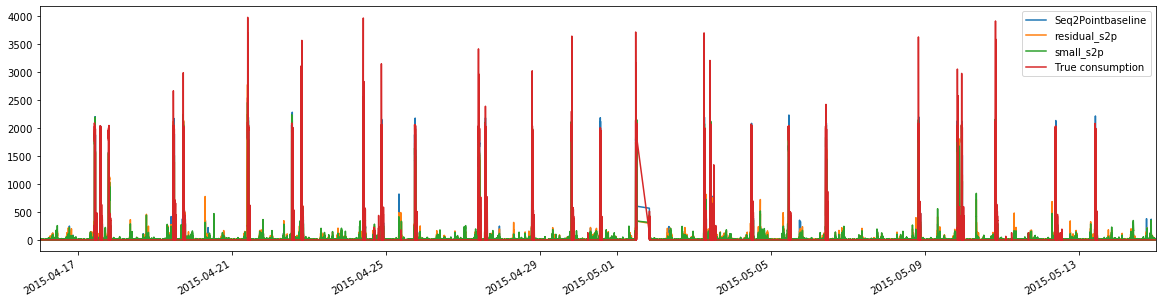

In [12]:
wm_results.plot(figsize=(20,5))

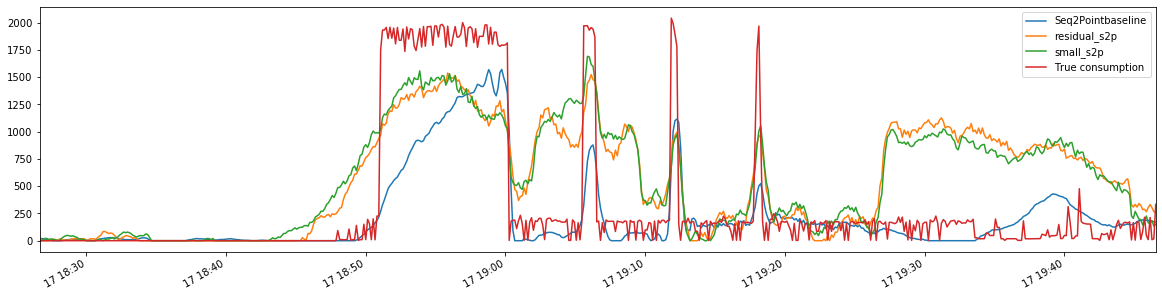

In [13]:
wm_results.iloc[19100:19700].plot(figsize=(20,5))